# DeepAR


In [1]:
# Installation of gluonTS
!pip uninstall numpy # Downgrade numpy to 1.23
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1
!pip install gluonts==0.14.2
!pip install yfinance

Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 74.7 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.1
    Uninstalling graphviz-0.20.1:
      Successfully uninstalled graphviz-0.20.1
ERROR: pip's dependency resolver does not currently take into account 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.9 MB/s eta 0:00:00


In [14]:
import yfinance as yf
orig = yf.download(["SPY","MSFT","AMZN","GOOG","PGR"], start="2020-01-01", end="2024-12-31")
orig = orig[[('Adj Close', 'AMZN'),('Adj Close', 'GOOG'),('Adj Close', 'MSFT'),('Adj Close',  'PGR'),('Adj Close',  'SPY')]]
orig.columns = ['AMZN','GOOG','MSFT','PGR','SPY']

[*********************100%%**********************]  5 of 5 completed


In [15]:
data = orig
data
# You can also re-sample to monthly
# data = orig.asfreq('M').ffill()


,AMZN,GOOG,MSFT,PGR,SPY
Date,,,,,
2020-01-02,94.900497,68.368500,154.493805,66.445465,305.058441
2020-01-03,93.748497,68.032997,152.570160,66.436539,302.748413
2020-01-06,95.143997,69.710503,152.964508,67.643333,303.903473
2020-01-07,95.343002,69.667000,151.569778,67.126694,303.048950
2020-01-08,94.598503,70.216003,153.984039,67.523415,304.664093
...,...,...,...,...,...
2024-02-12,172.339996,148.729996,414.493500,182.360001,500.980011
2024-02-13,168.639999,146.369995,405.570007,182.080002,494.079987
2024-02-14,170.979996,147.139999,409.489990,187.949997,498.570007


In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Stocks')

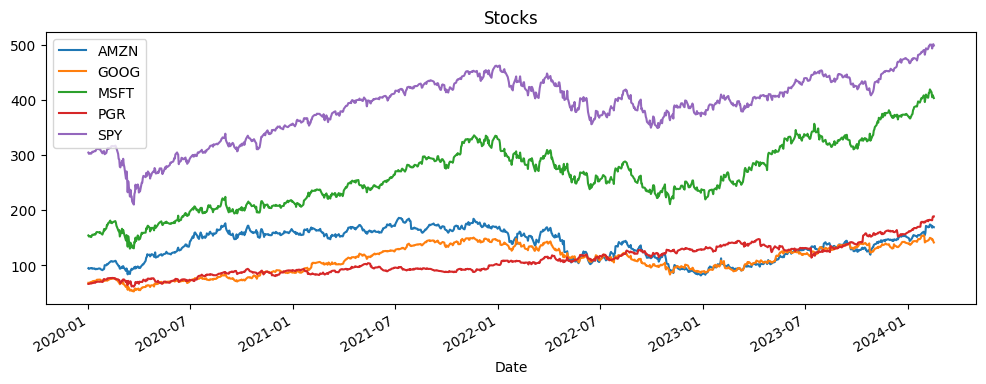

In [17]:
data.plot(figsize=(12, 4))
plt.legend(loc='upper left')
plt.title("Stocks")

In [18]:
print("The time series has", data.shape[0], "data points")

The time series has 1039 data points


In [19]:
len_train = int(data.shape[0] * 0.85)
train_data = data[0:len_train]
test_data = data[len_train:]
[train_data.shape, test_data.shape]

[(883, 5), (156, 5)]

## GluonTS data preparation

In [20]:
# Prepare the data for deepAR format
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def to_deepar_format(dataframe, freq):
    start_index = dataframe.index.min()
    data = [{
                FieldName.START:  start_index,
                FieldName.TARGET:  dataframe[c].values,
            }
            for c in dataframe.columns]
    print(data[0])
    return ListDataset(data, freq=freq)
train_data_lds = to_deepar_format(train_data, 'D')
test_data_lds = to_deepar_format(test_data, 'D')

{'start': Timestamp('2020-01-02 00:00:00'), 'target': array([ 94.90049744,  93.74849701,  95.14399719,  95.34300232,
        94.59850311,  95.05249786,  94.15799713,  94.56500244,
        93.47200012,  93.10099792,  93.89700317,  93.23600006,
        94.59999847,  94.3730011 ,  94.22899628,  93.08200073,
        91.41699982,  92.66249847,  92.90000153,  93.53399658,
       100.43599701, 100.20999908, 102.48349762, 101.99349976,
       102.5114975 , 103.96399689, 106.69550323, 107.54000092,
       108.        , 107.49349976, 106.74349976, 107.78350067,
       108.51100159, 107.65499878, 104.79850006, 100.46450043,
        98.63700104,  98.97949982,  94.21499634,  94.1875    ,
        97.69750214,  95.44950104,  98.79149628,  96.20149994,
        95.05449677,  90.03050232,  94.59100342,  91.04299927,
        83.83049774,  89.25      ,  84.45749664,  90.39199829,
        91.5       ,  94.04650116,  92.30449677,  95.14150238,
        97.00499725,  94.29199982,  97.77449799,  95.00499725,
 

DeepAR Basic Hyperparameters:

- prediction_length: How many steps the model is going to predict
- context_length: The number of time-points that the model gets to see before making the prediction. The value for this parameter should be about the same as the prediction_length.
- epochs: The maximum number of passes over the training data. Typical values range from 10 to 1000.
- num_cells: The number of cells to use in each hidden layer of the RNN. Typical values range from 30 to 100.
- num_layers: The number of hidden layers in the RNN. Typical values range from 1 to 4.

In [21]:
# api: https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.model.deepar.html
# paper: Salinas, David, Valentin Flunkert, and Jan Gasthaus. “DeepAR: Probabilistic forecasting with autoregressive recurrent networks.” arXiv preprint arXiv:1704.04110 (2017).

from gluonts.mx.model.deepar import DeepAREstimator
#from gluonts.torch.model.deepar.estimator import DeepAREstimator
from gluonts.mx.trainer import Trainer

prediction_length = 30
context_length = 30
num_cells = 100
num_layers = 8
epochs= 150
freq="D" # Our data is daily

estimator =   DeepAREstimator(freq=freq,
                                context_length=context_length,
                                prediction_length=prediction_length,
                                num_layers=num_layers,
                                num_cells=num_cells,
                                cardinality=[1],
                                trainer=Trainer(epochs=epochs))
predictor = estimator.train(train_data_lds)

100%|██████████| 50/50 [00:46<00:00,  1.08it/s, epoch=150/150, avg_epoch_loss=2.23]


In [22]:
from gluonts.evaluation.backtest import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data_lds,
    predictor=predictor,
)
tss = list(ts_it)
forecasts = list(forecast_it)

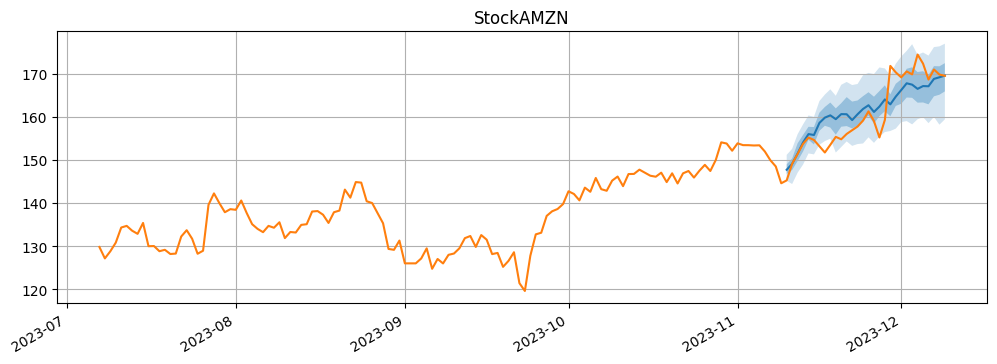

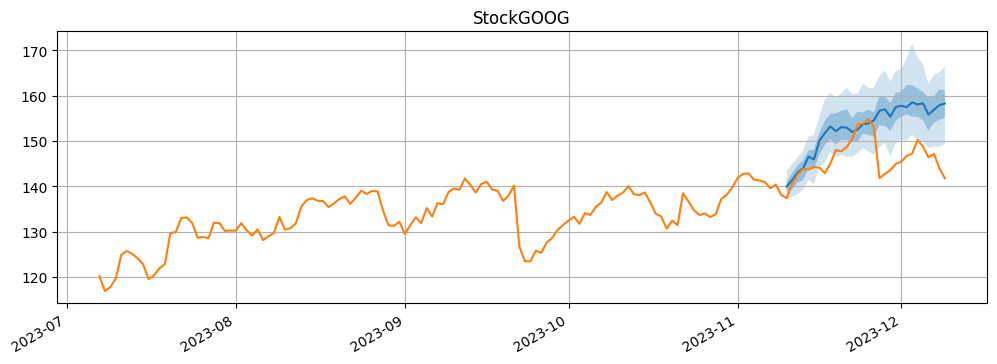

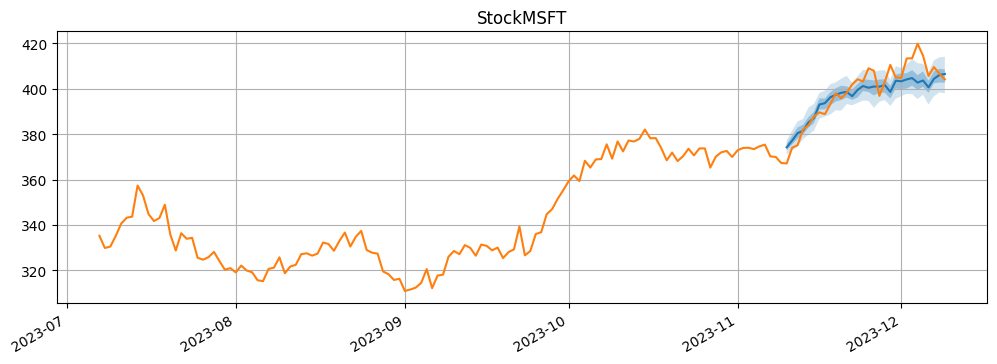

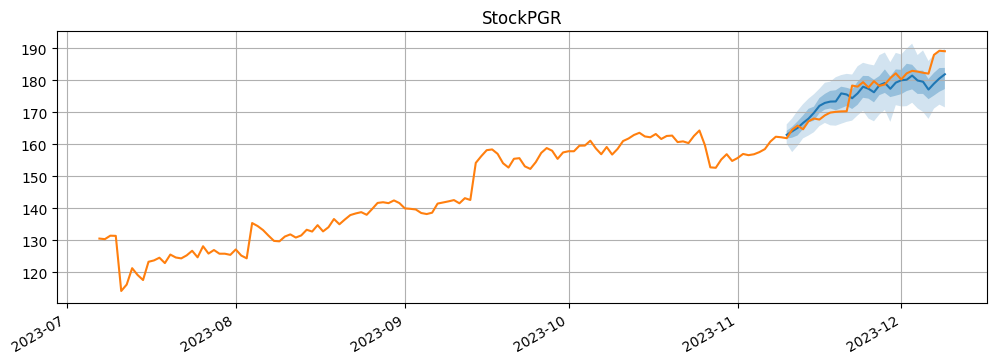

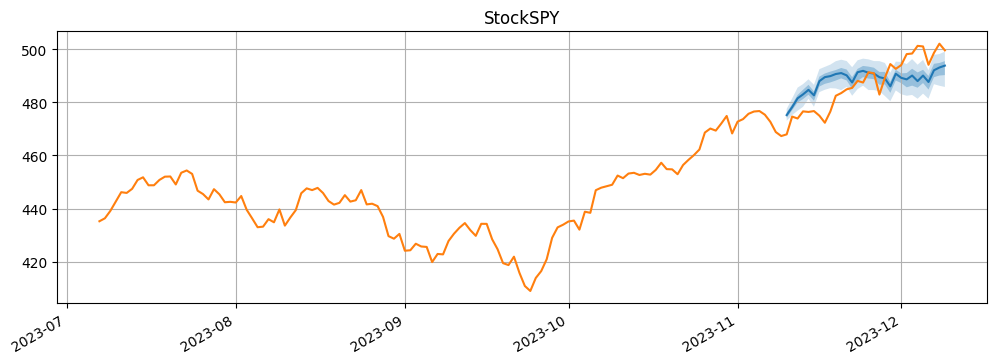

In [23]:
for k in range(len(forecasts)):
  fig, ax1 = plt.subplots(1, 1, figsize=(12, 4))
  forecasts[k].plot(ax = ax1)
  tss[k].plot(ax = ax1)
  ax1.get_legend().remove()
  plt.grid(which="both")
  plt.title("Stock" + data.columns[k])
  plt.show()

In [24]:
from gluonts.evaluation import Evaluator

evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_data_lds))

import json
print(json.dumps(agg_metrics, indent=4))

Running evaluation: 100%|██████████| 5/5 [00:00<00:00, 82.07it/s]

{
    "MSE": 41.4098828125,
    "abs_error": 743.3964691162109,
    "abs_target_sum": 41060.6259765625,
    "abs_target_mean": 273.73750651041667,
    "seasonal_error": 2.2641952880859373,
    "MASE": 2.356861690088161,
    "MAPE": 0.0222131609916687,
    "sMAPE": 0.02188496212164561,
    "MSIS": 21.42736430581951,
    "num_masked_target_values": 0.0,
    "QuantileLoss[0.1]": 449.42638244628915,
    "Coverage[0.1]": 0.2666666666666667,
    "QuantileLoss[0.2]": 617.0498840332032,
    "Coverage[0.2]": 0.35333333333333333,
    "QuantileLoss[0.3]": 710.0877990722655,
    "Coverage[0.3]": 0.4533333333333333,
    "QuantileLoss[0.4]": 750.3131042480468,
    "Coverage[0.4]": 0.5066666666666666,
    "QuantileLoss[0.5]": 743.3964691162109,
    "Coverage[0.5]": 0.5666666666666667,
    "QuantileLoss[0.6]": 707.8507934570313,
    "Coverage[0.6]": 0.6599999999999999,
    "QuantileLoss[0.7]": 640.9473663330078,
    "Coverage[0.7]": 0.74,
    "QuantileLoss[0.8]": 529.5050292968749,
    "Coverage[0.8]"